# Related to figure 4d

In [1]:
library(Seurat)
library(glue)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(msigdbr)

# Load rds
obj_merged <- readRDS('/data/yuchen_data/Stereo_seq/All_Figures/Figure4/1.data/panelDEF.rds')
obj_merged <- NormalizeData(obj_merged, normalization.method = "LogNormalize", scale.factor = 10000)
obj_merged

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




An object of class Seurat 
33238 features across 50942 samples within 1 assay 
Active assay: Spatial (33238 features, 0 variable features)
 13 images present: slice1, slice1.1, slice1.2, slice1.3, slice1.4, slice1.5, slice1.6, slice1.7, slice1.8, slice1.9, slice1.10, slice1.11, slice1.12

In [4]:
# get TLS group information
df_group = read.table('/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/TLS_group.1125.txt', row.names=1, header=T)
deviating_tls = row.names(df_group[df_group$Group == 'NotMature', ,drop=F])
mature_tls = row.names(df_group[df_group$Group == 'Mature', ,drop=F])
used_tls = c(deviating_tls, mature_tls)

In [5]:
# calculate TRYPTOPHAN_METABOLISM score
all_gene_sets <- msigdbr(species = "Homo sapiens")
all_gene_sets <- as.data.frame(all_gene_sets)

genesets <- c('KEGG_TRYPTOPHAN_METABOLISM')
gl <- list()
for (setid in genesets) {
    cur_gene = all_gene_sets$gene_symbol[all_gene_sets$gs_name == setid]
    gl[[setid]] = c(unique(cur_gene), c('SLC6A19','ACE2','CLTRN','SLC15A1','SLC15A2','SLC7A5','SLC3A2','SLC7A8','SLC16A10','SLC6A14','SLC1A5'))
}

obj_merged <- AddModuleScore(obj_merged, gl, name=names(gl))
obj_merged <- subset(obj_merged, subset=SpotLight_Anno!='noType')

df_score = obj_merged@meta.data
df_score$SpotLight_Anno[df_score$SpotLight_Anno == 'Plasma'] = 'B'
df_score$SpotLight_Anno[df_score$SpotLight_Anno == 'pDC'] = 'Myeloid'
obj_merged@meta.data = df_score

df_mature = subset(df_score, subset=TLS_expand_12%in%mature_tls)
df_deviating = subset(df_score, subset=TLS_expand_12%in%deviating_tls)


df_rst = data.frame(df_deviating %>% group_by(SpotLight_Anno) %>% summarise_at('KEGG_TRYPTOPHAN_METABOLISM1', list(name = mean)))
df_rst_mature = data.frame(df_mature %>% group_by(SpotLight_Anno) %>% summarise_at('KEGG_TRYPTOPHAN_METABOLISM1', list(name = mean)))

celltypes = c('B', 'T', 'Myeloid', 'Endothelial', 'Fibroblast', 'Tumor')
colors = c('#008000','#cac0e7','#6a60a9','#1f78b4','#df65b0','#ff0000')
names(colors) = celltypes


df_deviating$scaled_value = (df_deviating$KEGG_TRYPTOPHAN_METABOLISM1 - min(df_deviating$KEGG_TRYPTOPHAN_METABOLISM1)) / (max(df_deviating$KEGG_TRYPTOPHAN_METABOLISM1) - min(df_deviating$KEGG_TRYPTOPHAN_METABOLISM1))

Warning message:
“The following features are not present in the object: WARS1, not searching for symbol synonyms”


Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


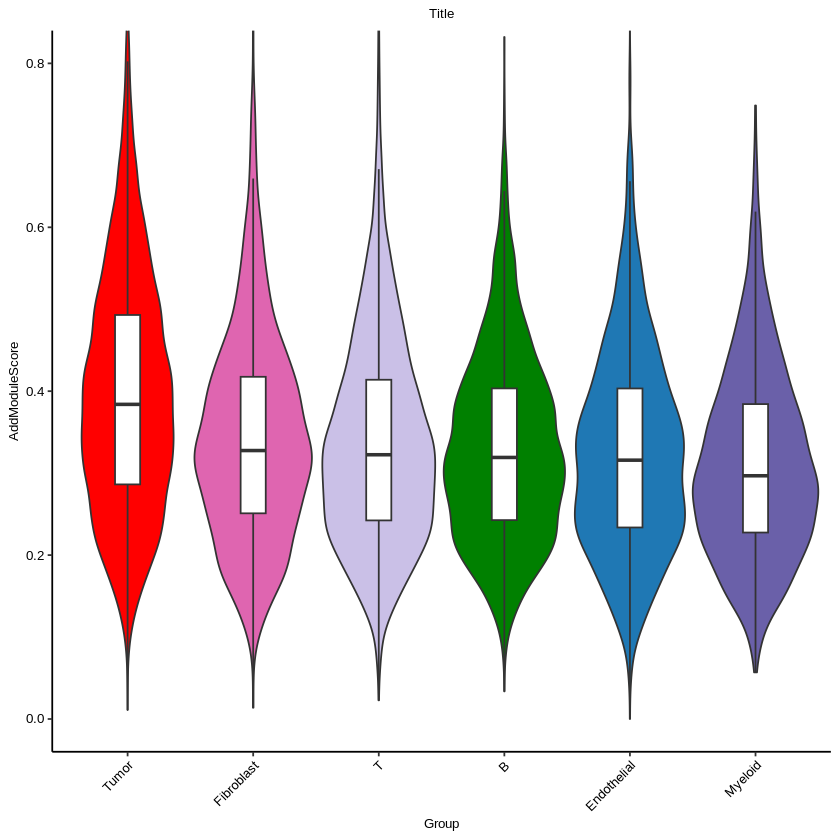

In [6]:
df_plot1 = df_deviating
plot_item = 'scaled_value'
group_item = 'SpotLight_Anno'

df_plot1$plot = df_plot1[[plot_item]]
df_plot1$groupby = df_plot1[[group_item]]

# 按中位数从高到低排序，看实际情况也可以不排序
df_tmp = data.frame(df_plot1 %>% group_by(groupby) %>% summarise(tmp=median(plot)))
group_order <- df_tmp[rev(order(df_tmp$tmp)), ]$groupby
df_plot1$groupby = factor(df_plot1$groupby, levels=group_order)
color_order = as.character(sapply(group_order, function(x) colors[[x]]))


mylist <- lapply(setdiff(group_order, c('Tumor')), function(i) c('Tumor', i))

ggplot(df_plot1, aes(groupby,plot ,fill=groupby))+
    geom_violin(width=1)+
    scale_fill_manual(limits=group_order, values=color_order)+ #颜色
    stat_compare_means(comparisons=mylist, label="p.format",method = 'wilcox.test', symnum.args=list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05, 1),symbols = c("****", "***", "**", "*", "ns"))) +
    guides(fill=FALSE) + 
    coord_cartesian(ylim = c(0, 0.8)) + 
    geom_boxplot(width=0.2, fill="white", outlier.alpha=0)+
    labs(title = 'Title',x = 'Group',y = 'AddModuleScore' ) +
    theme(
    plot.title    = element_text(color = 'black', size   = 8, hjust = 0.5),
    plot.subtitle = element_text(color = 'black', size   = 8,hjust = 0.5),
    plot.caption  = element_text(color = 'black', size   = 8,face = 'italic', hjust = 1),
    axis.text.x   = element_text(color = 'black', size = 8, angle = 45,hjust = 1),#
    axis.text.y   = element_text(color = 'black', size = 8, angle = 0),
    axis.title.x  = element_text(color = 'black', size = 8, angle = 0),
    axis.title.y  = element_text(color = 'black', size = 8, angle = 90),
    legend.title  = element_text(color = 'black', size  = 8),
    legend.text   = element_text(color = 'black', size   = 8),
    axis.line.y = element_line(color = 'black', linetype = 'solid'), # y轴线特征
    axis.line.x = element_line (color = 'black',linetype = 'solid'), # x轴线特征
    panel.background=element_rect(fill="white"), 
    # panel.border = element_rect(linetype = 'solid', size = 1.2,fill = NA) # 图四周框起来
    )